In [1]:
# import packages
%matplotlib notebook

import numpy as np
import pylab as plt
import seaborn as sns
import pandas as pd
import scipy
import matplotlib
from matplotlib.collections import PolyCollection

# Data Overview

In [2]:
data = pd.read_csv('data/connectivity_latency_7.csv')
data.head()

,Animal,Cell,Site,Slice,Type,EPSC,EPSC_baseline,EPSP,EPSP_baseline,ifSpiked
0,1255,4,LM,j130507a,L23PV,48.660958,1.61611,5.530275,0.164631,1.0
1,1255,8,LM,j130507a,L23pyr,91.203156,1.54484,2.507763,0.081332,0.0
2,1255,5,LM,j130507a,L23pyr,NaN,NaN,0.313296,0.059874,0.0
3,1255,6,LM,j130507a,L23pyr,NaN,NaN,0.000000,0.286458,0.0
4,1255,7,LM,j130507a,L23pyr,NaN,NaN,0.437592,0.079763,0.0


This data frame contained processed data of feedback connection experiments (Figure 3).

+ **Animal**: animal identifier
+ **Cell**: cell identifier within a slice
+ **Site**: injection site of virus expressing ChR2-YFP, LM or vM1
+ **Type**: cell type, layer + genetic type. pyr cells include pyramidal cells and excitatory neurons in L4. We did not dicriminate cells in L1
+ **EPSC**: peak amplitude of EPSC, normalized to baseline value before light stimulus, in pA. NaN marks that there was no EPSC recording for this cell, while 0 means the cell was not responsive: the peak EPSC amplitude was smaller than 3 times the standard deviation of baseline current value, or the latency is greater than 7ms, above which the event was identified as polysynaptic.
+ **EPSC_baseline**: average baseline value of EPSC traces, not used in the rest of the notebook
+ **EPSP**: same as EPSC, but for EPSP recordings
+ **EPSP_baseline**: average baseline value of EPSP traces, not used in the rest of the notebook
+ **ifSpiked**: whether the cell spiked in this recording

# Compute the log2 normalized EPSC and EPSP amplitudes

In [3]:
clip = {'EPSC': -7, 'EPSP': -6}

for dv in ['EPSC', 'EPSP']:
    y = data[dv].values.copy()
    
    for i, sl in enumerate(np.unique(data['Slice'])):
        ind = (data['Slice']==sl) & (data['Type']=='L23pyr')
        
        # if there is L23 pyramidal cell in the same slice, compute the normalized value
        if any(~np.isnan(y[ind])) and np.nanmean(y[ind]) > 0:
            y[data['Slice']==sl] /= np.nanmean(y[ind])
        # exclude this cell in the analysis otherwise
        else:
            y[data['Slice']==sl] = np.nan
    
    # replace 0 with small values to avoid negative infinity when taking the log.
    y[y == 0] = clip[dv]
    nn = [yy > 0 if ~np.isnan(yy) else False for yy in y]
    y[nn] = np.log2(y[nn])
    data[dv+'_logratio'] = y

# Plot Figure 3 - connectivity

<IPython.core.display.Javascript object>


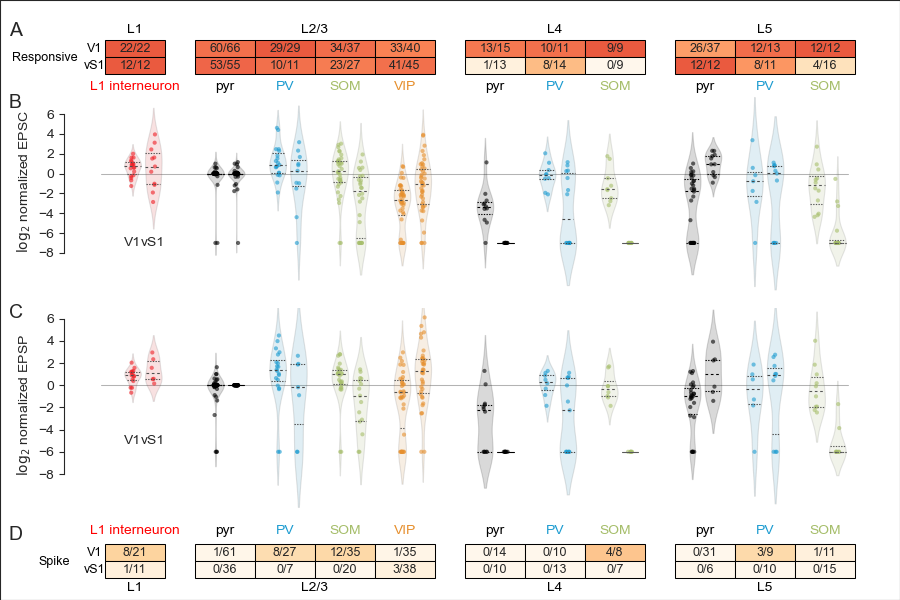

In [4]:
# Figure layout settings
sns.set_style('ticks')
fig, ax = plt.subplots(2, 1, figsize=(9, 6))
cell_types = ['L1','L23pyr','L23PV','L23SST','L23VIP','L4pyr','L4PV','L4SST','L5pyr','L5PV','L5SST']
colors = {'L1': '#ee1d23', 
          'L23pyr': '#000000', 'L23PV': '#1b9bd0', 'L23SST': '#a6be6b', 'L23VIP': '#e68f2d', 
          'L4pyr':  '#000000', 'L4PV':  '#1b9bd0', 'L4SST':  '#a6be6b',
          'L5pyr':  '#000000', 'L5PV':  '#1b9bd0', 'L5SST':  '#a6be6b'}
labels = {'L1': 'L1', 
          'L23pyr': 'pyr', 'L23PV': 'PV', 'L23SST': 'SOM', 'L23VIP': 'VIP', 
          'L4pyr':  'pyr', 'L4PV':  'PV', 'L4SST':  'SOM',
          'L5pyr':  'pyr', 'L5PV':  'PV', 'L5SST':  'SOM'}
yticks = {'EPSC': [-8, -6, -4, -2, 0, 2, 4, 6], 'EPSP': [-8, -6, -4, -2, 0, 2, 4, 6, 8]}
horizontal_positions = np.array([0, 1.5, 2.5, 3.5, 4.5, 6, 7, 8, 9.5, 10.5, 11.5])
ylims = {'EPSC': [-12, 16], 'EPSP': [-18, 7]}

full_positions = np.arange(-0.5, 12, 0.5)
v1_offset = 0.2
s1_offset = 0.4
linewidth = 0.8
marker_size = 3
positions = np.hstack(np.array([[pos + v1_offset, pos + s1_offset] if pos in horizontal_positions else [pos] 
                                for pos in full_positions], dtype=object))


# Plot panel B and C

for subplnum, dv in enumerate(['EPSC', 'EPSP']):
    plt.sca(ax[subplnum])
    for i, cell_type in enumerate(cell_types):
        
        # plot the cells in V1
        subdata = data[(data['Type']==cell_type) & (data['Site']=='LM')].copy()
        
        # x position of the dots
        subdata['x'] = list(np.full(np.shape(subdata['Cell']), horizontal_positions[i] + v1_offset))
        
        sns.violinplot(x='x', y=dv+'_logratio', data=subdata, color=colors[cell_type], 
                       order=positions, linewidth=linewidth, ax=ax[subplnum], 
                       inner='quartile')
        sns.stripplot(x='x', y=dv+'_logratio', data=subdata, jitter=True, color=colors[cell_type], 
                      order=positions, zorder=1, ax=ax[subplnum], size=marker_size, alpha=0.6)
        
        # plot the cells in vS1
        subdata = data[(data['Type']==cell_type) & (data['Site']=='vM1')].copy()
        
        # x position of the dots
        subdata['x'] = list(np.full(np.shape(subdata['Cell']), horizontal_positions[i] + s1_offset))
        sns.violinplot(x='x', y=dv+'_logratio', data=subdata, color=colors[cell_type], 
                       order=positions, linewidth=linewidth, inner='quartile', ax=ax[subplnum])
        sns.stripplot(x='x', y=dv+'_logratio', data=subdata, jitter=True, color=colors[cell_type], 
                      order=positions, zorder=1, ax=ax[subplnum], size=marker_size, alpha=0.6)
        
    plt.xlabel('')
    plt.ylabel(r'$\log_2$ normalized ' + dv)
    plt.plot(ax[subplnum].get_xlim(), [0, 0], linewidth=.75, color=[.7, .7, .7], zorder=0)
    plt.xticks([])
    plt.yticks(yticks[dv])
    plt.text(1, -7+2*subplnum, 'V1', rotation=0, va='center', ha='center')
    plt.text(2, -7+2*subplnum, 'vS1', rotation=0, va='center', ha='center')
    plt.ylim(ylims[dv])
    for art in ax[subplnum].get_children():
        if isinstance(art, PolyCollection):
            art.set_alpha(0.15)
    
pos = ax[0].yaxis.get_label().get_position()
ax[0].yaxis.get_label().set_position(pos + np.array((0, -0.1)))
pos = ax[1].yaxis.get_label().get_position()
ax[1].yaxis.get_label().set_position(pos + np.array((0, 0.15)))

sns.despine(bottom=True, trim=True)
plt.tight_layout()

ax0 = plt.axes([0,0,1,1], facecolor='none')
ax0.xaxis.set_visible(False)
ax0.yaxis.set_visible(False)
colormap = plt.cm.OrRd(np.linspace(0, 0.65, 101))
horizontal_positions = horizontal_positions/15+.15
dx = 1/15
dy = .028

# Plot pannel A as a chart
for i, cell_type in enumerate(cell_types):
    for site, h in zip(['LM', 'vM1'], [.89 + dy, .89]):
        n = data[(data['Type']==cell_type) & (data['Site']==site) & ((data['EPSC']>=0) | (data['EPSP']>=0))].shape[0]
        m = data[(data['Type']==cell_type) & (data['Site']==site) & ((data['EPSC']>0) | (data['EPSP']>0))].shape[0]
        plt.text(horizontal_positions[i], h, '{}/{}'.format(m, n), fontsize=9, ha='center', va='center')
        rect = plt.Rectangle((horizontal_positions[i] - dx/2, h - dy*.45), dx, dy, edgecolor='k', linewidth=.75,
                             facecolor=colormap[np.round(100*(m)/n).astype(int)])  
        plt.gca().add_patch(rect)
plt.text(.105, .89 + dy, 'V1', color='k', fontsize=9, ha='center', va='center')
plt.text(.105, .89, 'vS1', color='k', fontsize=9, ha='center', va='center')
plt.text(.05, .89 + dy/2, 'Responsive', color='k', fontsize=9, ha='center', va='center')
for label,pos in zip(['L1', 'L2/3', 'L4', 'L5'], np.array([0, 3, 7, 10.5]) / 15 + .15):
     plt.text(pos, .95, label, color='k', ha='center', va='center')
     plt.text(pos, 0.02, label, color='k', ha='center', va='center')
for i, cell_type in enumerate(cell_types):
    if cell_type != 'L1':
        plt.text(horizontal_positions[i], .85, labels[cell_type], color=colors[cell_type], ha='center')
    else:
        plt.text(0.15, .85, 'L1 interneuron', color='red', ha='center')

# Plot pannel D as a chart
for i, cell_type in enumerate(cell_types):
    for site, h in zip(['LM', 'vM1'], [.05+dy, .05]):
        n = data[(data['Type']==cell_type) & (data['Site']==site) & ~np.isnan(data['ifSpiked'])].shape[0]
        m = data[(data['Type']==cell_type) & (data['Site']==site) & (data['ifSpiked']==0)].shape[0]
        plt.text(horizontal_positions[i], h, '{}/{}'.format(n-m,n), fontsize=9, ha='center', va='center')
        rect = plt.Rectangle((horizontal_positions[i]-dx/2, h-dy*.45), dx, dy, edgecolor='k', linewidth=.75,
                             facecolor=colormap[np.round(100*(n-m)/n).astype(int)])  
        plt.gca().add_patch(rect)
plt.text(.105, .05+dy, 'V1', color='k', fontsize=9, ha='center', va='center')
plt.text(.105, .05, 'vS1', color='k', fontsize=9, ha='center', va='center')
plt.text(.06,  .05+dy/2, 'Spike', color='k', fontsize=9, ha='center', va='center')
for i, cell_type in enumerate(cell_types):
    if cell_type != 'L1':
        plt.text(horizontal_positions[i], .11, labels[cell_type], color=colors[cell_type], ha='center')
    else:
        plt.text(0.15, .11, 'L1 interneuron', color='red', ha='center')   


# Add panel numbers
plt.gcf().text(0.01, 0.94, 'A', fontsize=14)
plt.gcf().text(0.01, 0.82, 'B', fontsize=14)
plt.gcf().text(0.01, 0.47, 'C', fontsize=14)
plt.gcf().text(0.01, 0.10, 'D', fontsize=14)

plt.savefig('Figure3.png', dpi=300)

# Testing

We did multiple testings on the normalized EPSC and EPSP results.

1. For each area, test whether their normalized EPSP or EPSC are statistically the same across cell types.
2. For each area, perform paired comparison between the normalized EPSP or EPSC of each pair of cell types.
3. For each cell type, compare the normalized EPSP or EPSC recorded in different area (V1 or vS1).

## Kruskal-Wallis test across 10 cell types for each area

In [5]:
# Kruskal-Wallis across 10 cell types (L23pyr is excluded because it's normalized to 0)

from scipy.stats import kruskal

for site in ['LM', 'vM1']:
    for dv in ['EPSC', 'EPSP']:
        testdata = [data[(data['Type']==cell_type) & (data['Site']==site)][dv+'_logratio'].dropna().values 
                    for cell_type in cell_types if cell_type != 'L23pyr']
        p = kruskal(*testdata).pvalue
        print(site + '\t' + dv + '\t{:.1e}'.format(p))

LM	EPSC	2.6e-13
LM	EPSP	7.7e-07
vM1	EPSC	9.5e-12
vM1	EPSP	1.2e-07


Conclusion: For each area, both EPSC and EPSP were not the same across cell types.

## Paired comparison between each pair of cell types within one area

+ To compare normalized EPSC or ESPP between cell types other than L23pyr, we performed Conver test (post-hoc after Kruskal-Wallis).
+ To compare normalized EPSC or EPSP between L23pyr and other types, we performed permutation test.
+ To correct for multiple comparison, we performed Benjamin-Hochberg adjustments in both tests.

In [6]:
# THIS DOES 55*4+20 = 240 tests and then applies Benjamini-Hochberg adjustments
# to all these 240 p-values.

# Run `pip install scikit-posthocs` first

import scikit_posthocs as sp
from statsmodels.stats.multitest import multipletests
from IPython.display import display

def permutation_sign_test(x, nrep=1000, seed=42):
    means = np.zeros(nrep)
    np.random.seed(seed)
    for i in range(nrep):
        means[i] = np.mean(x * np.random.binomial(1,.5,size=x.size))
    pval = np.mean(np.abs(np.mean(x)) <= np.abs(means))
    if pval == 0:
        pval = 1/nrep
    return pval

cell_types = ['L1','L23pyr','L23PV','L23SST','L23VIP','L4pyr','L4PV','L4SST','L5pyr','L5PV','L5SST']

posthocs = {}
for site in ['LM', 'vM1']:
    for dv in ['EPSC', 'EPSP']:
        # Conover test (post-hoc after Kruskal-Wallis) -- 45 tests
        testdata = data[(data['Site']==site) & (data['Type']!='L23pyr') & ~np.isnan(data[dv+'_logratio'])]
        posthoc = sp.posthoc_conover(testdata, val_col = dv+'_logratio', group_col='Type')
        posthoc = posthoc[[cell_type for cell_type in cell_types if cell_type != 'L23pyr']]
        posthoc = posthoc.reindex([cell_type for cell_type in cell_types if cell_type != 'L23pyr'])

        # Permutation test to compare each type to L23pyr -- 10 tests
        permuts = []
        for cell_type in cell_types:
            if cell_type != 'L23pyr':
                x = testdata[testdata['Type'] == cell_type][dv + '_logratio'].values
                permuts.append(permutation_sign_test(x))

        # Combine them into one data frame
        posthoc['L23pyr'] = permuts
        posthoc.loc[11] = permuts + [-1]
        posthoc = posthoc.rename(index = {11: 'L23pyr'})
        posthoc = posthoc[cell_types]
        posthoc = posthoc.reindex(cell_types)
        
        posthocs[site + '-' + dv] = posthoc      
        
# FDR correction with Benjamin-Horchberg method
pvallist = []
for p in posthocs:
    ind = np.triu_indices(11, k=1)
    pvallist.extend(posthocs[p].values[ind])

pvallist = multipletests(pvallist, method='fdr_bh')[1]
for i, p in enumerate(posthocs):
    X = posthocs[p].values
    ind = np.triu_indices(11, k=1)
    X[ind]   = pvallist[i*55:(i+1)*55]
    X.T[ind] = pvallist[i*55:(i+1)*55]
        
        
for site in ['LM', 'vM1']:
    for dv in ['EPSC', 'EPSP']:
        print(site + ' ' + dv)
        with pd.option_context('display.float_format', '{:,.4f}'.format):
            display(posthocs[site + '-' + dv])

LM EPSC


,L1,L23pyr,L23PV,L23SST,L23VIP,L4pyr,L4PV,L4SST,L5pyr,L5PV,L5SST
L1,1.0000,0.0033,0.6292,0.2909,0.0000,0.0000,0.2692,0.0167,0.0000,0.0449,0.0052
L23pyr,0.0033,-1.0000,0.0058,0.7611,0.0033,0.0033,0.5241,0.0721,0.0033,0.2787,0.0506
L23PV,0.6292,0.0058,1.0000,0.0928,0.0000,0.0000,0.1240,0.0048,0.0000,0.0154,0.0011
L23SST,0.2909,0.7611,0.0928,1.0000,0.0000,0.0000,0.6963,0.0781,0.0000,0.1656,0.0314
L23VIP,0.0000,0.0033,0.0000,0.0000,1.0000,0.6589,0.0007,0.0459,0.4281,0.0475,0.0418
L4pyr,0.0000,0.0033,0.0000,0.0000,0.6589,1.0000,0.0019,0.0467,0.3254,0.0462,0.0471
L4PV,0.2692,0.5241,0.1240,0.6963,0.0007,0.0019,1.0000,0.2915,0.0055,0.4027,0.2040
L4SST,0.0167,0.0721,0.0048,0.0781,0.0459,0.0467,0.2915,1.0000,0.1607,0.8876,0.8829
L5pyr,0.0000,0.0033,0.0000,0.0000,0.4281,0.3254,0.0055,0.1607,1.0000,0.1505,0.1712
L5PV,0.0449,0.2787,0.0154,0.1656,0.0475,0.0462,0.4027,0.8876,0.1505,1.0000,0.7717


LM EPSP


,L1,L23pyr,L23PV,L23SST,L23VIP,L4pyr,L4PV,L4SST,L5pyr,L5PV,L5SST
L1,1.0000,0.0033,0.6903,0.7717,0.0043,0.0001,0.3376,0.1573,0.0004,0.1415,0.0802
L23pyr,0.0033,-1.0000,0.1036,0.2200,0.0058,0.0058,0.6742,0.5048,0.0033,0.3834,0.5048
L23PV,0.6903,0.1036,1.0000,0.4382,0.0003,0.0000,0.1810,0.0640,0.0000,0.0635,0.0278
L23SST,0.7717,0.2200,0.4382,1.0000,0.0024,0.0000,0.4233,0.1894,0.0001,0.1723,0.0943
L23VIP,0.0043,0.0058,0.0003,0.0024,1.0000,0.0517,0.2574,0.5318,0.3121,0.7218,0.6495
L4pyr,0.0001,0.0058,0.0000,0.0000,0.0517,1.0000,0.0148,0.0475,0.2792,0.1036,0.0546
L4PV,0.3376,0.6742,0.1810,0.4233,0.2574,0.0148,1.0000,0.6925,0.0733,0.6004,0.5592
L4SST,0.1573,0.5048,0.0640,0.1894,0.5318,0.0475,0.6925,1.0000,0.2082,0.8726,0.8726
L5pyr,0.0004,0.0033,0.0000,0.0001,0.3121,0.2792,0.0733,0.2082,1.0000,0.3508,0.2489
L5PV,0.1415,0.3834,0.0635,0.1723,0.7218,0.1036,0.6004,0.8726,0.3508,1.0000,0.9931


vM1 EPSC


,L1,L23pyr,L23PV,L23SST,L23VIP,L4pyr,L4PV,L4SST,L5pyr,L5PV,L5SST
L1,1.0000,0.2750,0.5048,0.0033,0.0616,0.0000,0.0014,0.0000,0.5602,0.0583,0.0000
L23pyr,0.2750,-1.0000,0.4509,0.0033,0.0033,0.0033,0.0033,0.0058,0.0211,0.0904,0.0033
L23PV,0.5048,0.4509,1.0000,0.0342,0.3233,0.0000,0.0127,0.0000,0.2088,0.2356,0.0000
L23SST,0.0033,0.0033,0.0342,1.0000,0.0922,0.0007,0.4910,0.0011,0.0003,0.5048,0.0022
L23VIP,0.0616,0.0033,0.3233,0.0922,1.0000,0.0000,0.0333,0.0000,0.0084,0.6182,0.0000
L4pyr,0.0000,0.0033,0.0000,0.0007,0.0000,1.0000,0.0128,1.0000,0.0000,0.0006,0.5003
L4PV,0.0014,0.0033,0.0127,0.4910,0.0333,0.0128,1.0000,0.0157,0.0001,0.2412,0.0440
L4SST,0.0000,0.0058,0.0000,0.0011,0.0000,1.0000,0.0157,1.0000,0.0000,0.0008,0.5048
L5pyr,0.5602,0.0211,0.2088,0.0003,0.0084,0.0000,0.0001,0.0000,1.0000,0.0124,0.0000
L5PV,0.0583,0.0904,0.2356,0.5048,0.6182,0.0006,0.2412,0.0008,0.0124,1.0000,0.0019


vM1 EPSP


,L1,L23pyr,L23PV,L23SST,L23VIP,L4pyr,L4PV,L4SST,L5pyr,L5PV,L5SST
L1,1.0000,0.0342,0.2078,0.0317,0.6459,0.0001,0.0058,0.0001,0.7611,0.2489,0.0002
L23pyr,0.0342,-1.0000,0.3017,0.0232,0.0616,0.0148,0.0106,0.0342,0.1726,0.3358,0.0058
L23PV,0.2078,0.3017,1.0000,0.4910,0.2348,0.0047,0.1806,0.0061,0.3404,0.8316,0.0106
L23SST,0.0317,0.0232,0.4910,1.0000,0.0068,0.0093,0.4252,0.0138,0.0733,0.2932,0.0232
L23VIP,0.6459,0.0616,0.2348,0.0068,1.0000,0.0000,0.0005,0.0000,0.9433,0.2787,0.0000
L4pyr,0.0001,0.0148,0.0047,0.0093,0.0000,1.0000,0.0616,1.0000,0.0003,0.0011,0.7148
L4PV,0.0058,0.0106,0.1806,0.4252,0.0005,0.0616,1.0000,0.0753,0.0167,0.0754,0.1332
L4SST,0.0001,0.0342,0.0061,0.0138,0.0000,1.0000,0.0753,1.0000,0.0005,0.0019,0.7218
L5pyr,0.7611,0.1726,0.3404,0.0733,0.9433,0.0003,0.0167,0.0005,1.0000,0.4217,0.0007
L5PV,0.2489,0.3358,0.8316,0.2932,0.2787,0.0011,0.0754,0.0019,0.4217,1.0000,0.0030


# Compare normalzied EPSC and EPSP of the same cell type across areas

+ To compare normalized EPSC and EPSP of the same cell type across areas, we performed Mann Whitney U test, with Benjamin-HochBerg method to adjust p values for multiple comparisons.

In [7]:
pvals = np.zeros((11, 2))
for i, dv in enumerate(['EPSC', 'EPSP']):
    for j, cell_type in enumerate(cell_types):
        pvals[j, i] = scipy.stats.mannwhitneyu(
            data[(data['Type']==cell_type) & (data['Site']=='LM')] [dv + '_logratio'].dropna(), 
            data[(data['Type']==cell_type) & (data['Site']=='vM1')][dv + '_logratio'].dropna(),
            alternative='two-sided').pvalue
# Benjamin-HochBerg adjustment of p-values
# (separately within S1 and V1)
from statsmodels.stats.multitest import multipletests
pvals_adjusted = pvals.copy()
for i in range(2):
    comparisons = np.array(cell_types)!='L23pyr'
    pvals_adjusted[:, i][comparisons] = multipletests(pvals[:, i][comparisons], method='fdr_bh')[1]

print('  V1 vs S1 comparison (Mann-Whitney test)')
print('------------------------------------------')
print('          EPSC     adj       EPSP     adj')
for cell_type, pv, pv_adj in zip(cell_types, pvals, pvals_adjusted):
    if cell_type != 'L23pyr':
        print(cell_type + '\t {:.4f}  {:.4f}     {:.4f}  {:.4f}'.format(pv[0], pv_adj[0], pv[1], pv_adj[1]))

  V1 vs S1 comparison (Mann-Whitney test)
------------------------------------------
          EPSC     adj       EPSP     adj
L1	 0.9105  0.9271     0.3706  0.4118
L23PV	 0.1822  0.2277     0.2560  0.3200
L23SST	 0.0005  0.0009     0.0074  0.0185
L23VIP	 0.0014  0.0023     0.0020  0.0066
L4pyr	 0.0002  0.0004     0.0191  0.0382
L4PV	 0.0687  0.0981     0.0618  0.0882
L4SST	 0.0002  0.0004     0.0016  0.0066
L5pyr	 0.0001  0.0004     0.0245  0.0408
L5PV	 0.9271  0.9271     0.5848  0.5848
L5SST	 0.0001  0.0004     0.0013  0.0066


To check the results with 4 ms as the latency cutoff (Figure S6), change the data path to `data/connectivity_latency_4.csv`

# Analyses of raw EPSP and EPSC with the same methods (Figure S7)

<IPython.core.display.Javascript object>


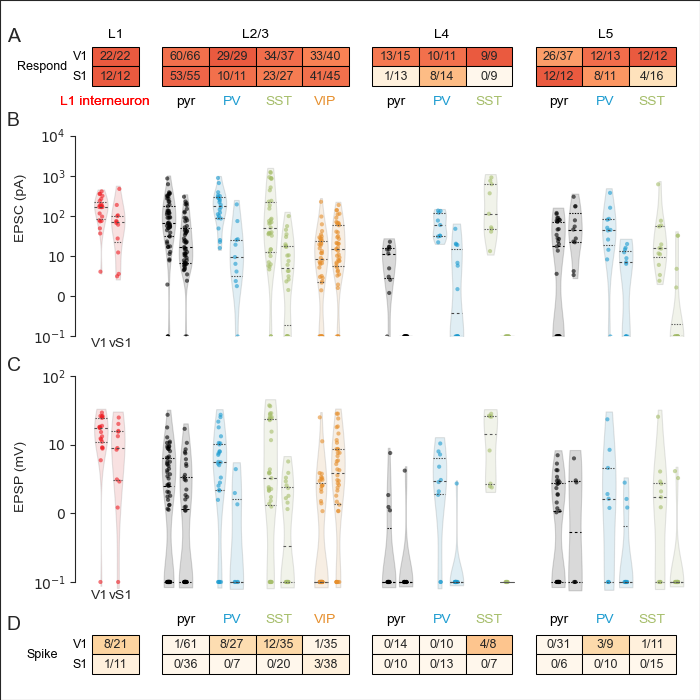

Text(0.01, 0.1, 'D')

In [8]:
np.random.seed(42)

sns.set_style('ticks')
fig, ax = plt.subplots(2, 1,figsize=(7, 7))
cell_types = ['L1','L23pyr','L23PV','L23SST','L23VIP','L4pyr','L4PV','L4SST','L5pyr','L5PV','L5SST']
colors = {'L1': '#ee1d23', 
          'L23pyr': '#000000', 'L23PV': '#1b9bd0', 'L23SST': '#a6be6b', 'L23VIP': '#e68f2d', 
          'L4pyr':  '#000000', 'L4PV':  '#1b9bd0', 'L4SST':  '#a6be6b',
          'L5pyr':  '#000000', 'L5PV':  '#1b9bd0', 'L5SST':  '#a6be6b'}
labels = {'L1': 'L1', 
          'L23pyr': 'pyr', 'L23PV': 'PV', 'L23SST': 'SST', 'L23VIP': 'VIP', 
          'L4pyr':  'pyr', 'L4PV':  'PV', 'L4SST':  'SST',
          'L5pyr':  'pyr', 'L5PV':  'PV', 'L5SST':  'SST'}

yticks = {'EPSC': [-1, 0, 1, 2, 3, 4], 'EPSP': [-1, 0, 1, 2]}
ytick_labels = {'EPSC': [r'$10^{-1}$', r'$0$', r'$10$', r'$10^2$', r'$10^3$', r'$10^4$'],
                'EPSP': [r'$10^{-1}$', r'$0$', r'$10$', r'$10^2$']}
yminorticks = {'EPSC': 
    list(np.arange(2, 10))+list(np.arange(20,100,10))+list(np.arange(200,1000,100)), 
               'EPSP': 
    list(np.arange(.20,1,.1))+list(np.arange(2,10))+list(np.arange(20,100,10))}


ylims = {'EPSC': [0, 7], 'EPSP': [-2.5, 2.18]}
horizontal_positions = np.array([0, 1.5, 2.5, 3.5, 4.5, 6, 7, 8, 9.5, 10.5, 11.5])
zerosat = {'EPSC': .8, 'EPSP': .08}

ylabels = {'EPSC': 'EPSC (pA)', 'EPSP': 'EPSP (mV)'}

full_positions = np.arange(-0.5, 12, 0.5)
v1_offset = 0.2
s1_offset = 0.4
linewidth = 0.8
marker_size = 3
positions = np.hstack(np.array([[pos + v1_offset, pos + s1_offset] if pos in horizontal_positions else [pos] 
                                for pos in full_positions], dtype=object))

pvals = np.zeros((11, 2))

# Plot 
for subplnum, dv in enumerate(['EPSC', 'EPSP']):
    plt.sca(ax[subplnum])
    for i, cell_type in enumerate(cell_types):
        pvals[i, subplnum] = scipy.stats.mannwhitneyu(
            data[(data['Type']==cell_type) & (data['Site']=='LM')] [dv].dropna(), 
            data[(data['Type']==cell_type) & (data['Site']=='vM1')][dv].dropna(),
            alternative='two-sided').pvalue

        subdata = data[(data['Type']==cell_type) & (data['Site']=='LM')].copy()
        
        # Reset the values to the bottom of the plot for cells that are not responsive
        subdata.loc[subdata[dv] < 1, dv] = 0.1
        subdata.replace([np.inf, -np.inf], np.nan, inplace=True)
        subdata.dropna()
        subdata[dv + '_log10'] = np.log10(subdata[dv])
        subdata['x'] = list(np.full(np.shape(subdata['Cell']), horizontal_positions[i] + v1_offset))
        
        sns.violinplot(x='x', y=dv + '_log10', data=subdata, color=colors[cell_type], 
                       order=positions, linewidth=linewidth, ax=ax[subplnum], 
                       inner='quartile', cut=0.2)
        sns.stripplot(x='x', y=dv + '_log10', data=subdata, jitter=True, color=colors[cell_type], 
                      order=positions, zorder=1, ax=ax[subplnum], size=marker_size, alpha=0.6)

        subdata = data[(data['Type'] == cell_type) & (data['Site']=='vM1')].copy()
        
        # Reset the values to the bottom of the plot for cells that are not responsive
        subdata.loc[subdata[dv] < 1, dv] = 0.1
        subdata.replace([np.inf, -np.inf], np.nan, inplace=True)
        subdata.dropna()
        subdata[dv + '_log10'] = np.log10(subdata[dv])
        subdata['x'] = list(np.full(np.shape(subdata['Cell']), horizontal_positions[i] + s1_offset))
        sns.violinplot(x='x', y=dv + '_log10', data=subdata, color=colors[cell_type], 
                       order=positions, linewidth=linewidth, inner='quartile', ax=ax[subplnum], cut=0.2)
        sns.stripplot(x='x', y=dv + '_log10', data=subdata, jitter=True, color=colors[cell_type], 
                      order=positions, zorder=1, ax=ax[subplnum], size=marker_size, alpha=0.6)
        
    plt.xlabel('')
    plt.ylabel(ylabels[dv])
  
    plt.xticks([])
    
    label_y_pos = -1.2
    plt.text(.9, label_y_pos, 'V1', rotation=0, va='center', ha='center')
    plt.text(2.2, label_y_pos, 'vS1', rotation=0, va='center', ha='center')
    
    plt.ylim(ylims[dv])
    plt.yticks(yticks[dv], ytick_labels[dv])
    
    for art in ax[subplnum].get_children():
        if isinstance(art, PolyCollection):
            art.set_alpha(0.15)
    
pos = ax[0].yaxis.get_label().get_position()
ax[0].yaxis.get_label().set_position(pos + np.array((0, -0.1)))
pos = ax[1].yaxis.get_label().get_position()
ax[1].yaxis.get_label().set_position(pos + np.array((0, 0.15)))

sns.despine(bottom=True, trim=True)
plt.tight_layout()

ax0 = plt.axes([0, 0, 1, 1], facecolor='none')
ax0.xaxis.set_visible(False)
ax0.yaxis.set_visible(False)
colormap = plt.cm.OrRd(np.linspace(0, 0.65, 101))
horizontal_positions = horizontal_positions / 15 + .165
dx = 1/15
dy = .028

for i, cell_type in enumerate(cell_types):
    for site, h in zip(['LM', 'vM1'], [.89+dy, .89]):
        n = data[(data['Type']==cell_type) & (data['Site']==site) & ((data['EPSC']>=0) | (data['EPSP']>=0))].shape[0]
        m = data[(data['Type']==cell_type) & (data['Site']==site) & ((data['EPSC']>0) | (data['EPSP']>0))].shape[0]
        plt.text(horizontal_positions[i], h, '{}/{}'.format(m,n), fontsize=9, ha='center', va='center')
        rect = plt.Rectangle((horizontal_positions[i]-dx/2, h-dy*.45), dx, dy, edgecolor='k', linewidth=.75,
                             facecolor=colormap[np.round(100*(m)/n).astype(int)])  
        plt.gca().add_patch(rect)
plt.text(.115, .89+dy, 'V1', color='k', fontsize=9, ha='center', va='center')
plt.text(.115, .89, 'S1', color='k', fontsize=9, ha='center', va='center')
plt.text(.06, .89+dy/2, 'Respond', color='k', fontsize=9, ha='center', va='center')
for label,pos in zip(['L1', 'L2/3', 'L4', 'L5'], np.array([0, 3, 7, 10.5])/15+.165):
     plt.text(pos, .95, label, color='k', ha='center', va='center')
for i, cell_type in enumerate(cell_types):
    if cell_type != 'L1':
        plt.text(horizontal_positions[i], .85, labels[cell_type], color=colors[cell_type], ha='center')
    else:
        plt.text(0.15, .85, 'L1 interneuron', color='red', ha='center')
        
for i, cell_type in enumerate(cell_types):
    for site, h in zip(['LM', 'vM1'], [.05+dy, .05]):
        n = data[(data['Type']==cell_type) & (data['Site']==site) & ~np.isnan(data['ifSpiked'])].shape[0]
        m = data[(data['Type']==cell_type) & (data['Site']==site) & (data['ifSpiked']==0)].shape[0]
        plt.text(horizontal_positions[i], h, '{}/{}'.format(n-m,n), fontsize=9, ha='center', va='center')
        rect = plt.Rectangle((horizontal_positions[i]-dx/2, h-dy*.45), dx, dy, edgecolor='k', linewidth=.75,
                             facecolor=colormap[np.round(100*(n-m)/n).astype(int)])  
        plt.gca().add_patch(rect)
plt.text(.115, .05+dy, 'V1', color='k', fontsize=9, ha='center', va='center')
plt.text(.115, .05, 'S1', color='k', fontsize=9, ha='center', va='center')
plt.text(.06,  .05+dy/2, 'Spike', color='k', fontsize=9, ha='center', va='center')
for i, cell_type in enumerate(cell_types):
    if cell_type != 'L1':
        plt.text(horizontal_positions[i], .11, labels[cell_type], color=colors[cell_type], ha='center')
    else:
        plt.text(0.15, .85, 'L1 interneuron', color='red', ha='center') 
plt.gcf().text(0.01, 0.94, 'A', fontsize=14)
plt.gcf().text(0.01, 0.82, 'B', fontsize=14)
plt.gcf().text(0.01, 0.47, 'C', fontsize=14)
plt.gcf().text(0.01, 0.10, 'D', fontsize=14)

In [9]:
# Compare raw EPSP and EPSC of the same cell type across feedback pathways
pvals = np.zeros((11, 2))
for i, dv in enumerate(['EPSC', 'EPSP']):
    for j, cell_type in enumerate(cell_types):
        pvals[j, i] = scipy.stats.mannwhitneyu(
            data[(data['Type']==cell_type) & (data['Site']=='LM')] [dv].dropna(), 
            data[(data['Type']==cell_type) & (data['Site']=='vM1')][dv].dropna(),
            alternative='two-sided').pvalue

# Benjamin-HochBerg adjustment of p-values
# (separately within S1 and V1)
from statsmodels.stats.multitest import multipletests
pvals_adjusted = pvals.copy()
for i in range(2):
    pvals_adjusted[:, i][comparisons] = multipletests(pvals[:, i][comparisons], method='fdr_bh')[1]

print('  V1 vs S1 comparison (Mann-Whitney test)')
print('------------------------------------------')
print('          EPSC     adj       EPSP     adj')
for cell_type, pv, pv_adj in zip(cell_types, pvals, pvals_adjusted):
    print(cell_type + '\t {:.4f}  {:.4f}     {:.4f}  {:.4f}'.format(pv[0], pv_adj[0], pv[1], pv_adj[1]))

  V1 vs S1 comparison (Mann-Whitney test)
------------------------------------------
          EPSC     adj       EPSP     adj
L1	 0.0183  0.0228     0.0680  0.0850
L23pyr	 0.0000  0.0000     0.1975  0.1975
L23PV	 0.0002  0.0003     0.0049  0.0087
L23SST	 0.0001  0.0003     0.0052  0.0087
L23VIP	 0.0563  0.0563     0.0005  0.0040
L4pyr	 0.0001  0.0003     0.0262  0.0375
L4PV	 0.0002  0.0003     0.0023  0.0057
L4SST	 0.0002  0.0003     0.0008  0.0040
L5pyr	 0.0388  0.0431     0.6646  0.6646
L5PV	 0.0045  0.0065     0.1494  0.1660
L5SST	 0.0002  0.0003     0.0015  0.0048
